In [339]:
"""Libraries"""
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from copy import copy, deepcopy
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge, Lasso
from bias_correction import BiasCorrection
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import mean_squared_error as mse

"""Notebook Settings"""
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

"""Variables"""
variables = ["tmean", "tmax", "tmin", "rain"]
temp_variables = ["tmean", "tmax", "tmin"]
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(8,11))
homogeneous_groups = list(range(1,5))
group_to_relative_production = {1:0.379, 2:0.219, 3:0.255, 4:0.147}

'Libraries'

'Notebook Settings'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'Variables'

## Content
* [1. Read Data](#read_data)
* [2. Bias-Adjustment](#bias_adjustment)
* [3. Dataset Completion](#dataset_completion)
* [4. Feature Computation](#feature_computation)
* [5. Include Yield Data](#yield_data)

In [333]:
def read_raw_model_data():
    """Reads and returns raw hindcasts from ECMWF, UKMO, NCEP and MME as one dataframe."""
    
    ukmo = pd.read_csv("Data/Raw Hindcasts as CSV/ukmo.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    ncep = pd.read_csv("Data/Raw Hindcasts as CSV/ncep.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    ecmwf = pd.read_csv("Data/Raw Hindcasts as CSV/ecmwf.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    
    df = pd.concat([ukmo, ncep, ecmwf])
    df = df.sort_values(by=["model", "init_month", "ensemble", "group", "year", "month", "date"])
    df = df.loc[df["init_month"] >= 8].reset_index(drop=True)
    
    ensemble_aggregation = (df
                            .groupby(["model", "init_month", "group", "year", "month", "date"])
                            .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                            .reset_index(drop=False))

    multi_model_ensemble = (df
                            .groupby(["init_month", "group", "year", "month", "date"])
                            .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                            .reset_index(drop=False)
                            .assign(model="MME")
                            .loc[:,ensemble_aggregation.columns])

    hindcasts = (pd.concat([ensemble_aggregation, multi_model_ensemble])
                 .rename(columns={"date":"time", "group":"zone"})
                 .set_index(["model", "init_month", "zone", "year", "month"])
                 .sort_index())
    
    return hindcasts

In [334]:
hindcasts = read_raw_model_data()

In [340]:
def read_observed_weather():
    """Reads and returns daily weather observations as dataframe."""
    
    weather_station_to_group_id = {"PFUN":1, "LOND":2, "CAMP":3, "PGRO":4}         
    all_files = glob.glob("Data/Observed Weather/*.csv")
    li = []
    for _, filename in enumerate(all_files):
        observations = pd.read_csv(filename,
                                   usecols=["date", "rain", "tmax", "tmin", "tmean", "treatment"], 
                                   dtype={"date":str}, 
                                   parse_dates=["date"])
        li.append(observations)
        
    observations = (pd
                    .concat(li, axis=0, ignore_index=False)
                    .assign(
                        model="WS", 
                        init_month=11, 
                        year=lambda x: x["date"].dt.year, 
                        month=lambda x: x["date"].dt.month)
                   )
    observations = observations.loc[(observations["month"].isin(months_of_crop_season))].reset_index(drop=True)
    
    observations["zone"] = observations["treatment"].apply(lambda x: weather_station_to_group_id[x])
    observations = (observations
                    .loc[:, ["model", "init_month", "zone", "year", "month", "date", "tmean", "tmax", "tmin", "rain"]]
                    .rename(columns={"date":"time"})
                    .set_index(["model", "init_month", "zone", "year", "month"])
                    .sort_index()
         )
    observations.loc[:, "tmean"] = observations.loc[:, "tmean"].fillna(observations.loc[:, "tmean"].mean())
    observations.loc[:, "tmax"] = observations.loc[:, "tmax"].fillna(observations.loc[:, "tmax"].mean())
    observations.loc[:, "tmin"] = observations.loc[:, "tmin"].fillna(observations.loc[:, "tmin"].mean())

    return observations

In [341]:
observations = read_observed_weather()

In [345]:
def create_climatology_data(observed):
    climatology = (observed
                 .loc[("WS", 11, [1, 2, 3, 4], list(range(1961,1993)), [8, 9, 10])]
                 .groupby(["zone", "year", "month"])
                 .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"sum"})
                 .reset_index()
                 .groupby(["zone", "month"])
                 .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                 .reset_index()
                 .copy())
    return climatology

In [346]:
climatology = create_climatology_data(observations)

In [349]:
observations = (observations
               .loc[("WS", 11, [1, 2, 3, 4], list(range(1993, 2017)))])

### 2. Bias-Adjustment <a name="bias_adjustment"></a>
Reference for [normal mapping](https://hess.copernicus.org/articles/21/2649/2017/) that is used for temp variables.

In [350]:
def adjust_mean_temperature_bias(observed, predicted, correction_method="normal_mapping"):
    """Return bias-adjusted hindcasts as Dataframe."""
    
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["zone", "year", "month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "zone", "year", "month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
 
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in crop_seasons: 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
                hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
                hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_tmax = BiasCorrection(observations_used_as_reference["tmax"], hindcasts_used_as_reference["tmax"], group_content["tmax"])
        bc_tmin = BiasCorrection(observations_used_as_reference["tmin"], hindcasts_used_as_reference["tmin"], group_content["tmin"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["tmax"] = bc_tmax.correct(method=correction_method)
        group_content["tmin"] = bc_tmin.correct(method=correction_method)
        
        li.append(group_content)
        
    result = pd.concat(li, axis=0, ignore_index=False)
    return result
            

In [351]:
hindcasts_temp_adjusted = adjust_mean_temperature_bias(observations, hindcasts)

In [363]:
def fill_missing_dates_with_observations(observations, model):
    """Supplements past months before init_month with weather observations."""
    
    model = model.copy()
    grouped_model_output = model.groupby(["model", "init_month", "zone", "year"])
    li=[]
    for group_characteristics, group_content in grouped_model_output:
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
        
        observations_for_zone_and_season = (observations
                                            .loc[("WS", 11, current_zone, current_season)])
        observations_for_zone_and_season = (observations_for_zone_and_season
                                            .assign(init_month=current_init_month, model=current_model)
                                           .set_index(["model", "init_month"], append=True))
        hindcasts_on_observations = observations_for_zone_and_season.merge(group_content, on="time", how="left", suffixes=("_ws", "_bcm"))
        hindcasts = hindcasts_on_observations.loc[:,[c for c in hindcasts_on_observations.columns if "_ws" not in c]]
        hindcasts.columns = hindcasts.columns.str.rstrip("_bcm")
        hindcasts = hindcasts.set_index("time")
        observations_for_zone_and_season = observations_for_zone_and_season.set_index("time")
        combined = hindcasts.combine_first(observations_for_zone_and_season)
        combined = (combined
                    .reset_index(drop=False)
                    .assign(model=current_model, init_month=current_init_month, 
                            zone=current_zone, year=current_season, month=lambda x: x["time"].dt.month)
                    .set_index(["model", "init_month", "zone", "year", "month"]))
        if current_init_month == 10:
            fully_observed = (observations_for_zone_and_season
                              .reset_index(drop=False)
                              .assign(model=current_model, init_month=11, zone=current_zone, year=current_season, month=lambda x:x["time"].dt.month)
                              .set_index(["model", "init_month", "zone", "year", "month"]))
            li.append(fully_observed)
        li.append(combined)

    result = pd.concat(li, axis=0, ignore_index=False).sort_index()
    #result = pd.concat([result, observations.loc[("WS", 11, [1, 2, 3, 4], [2017, 2018, 2019])]]).sort_index()
    result = result.query('(month >= 8) & (model != "WS") & (init_month < 11)')
    
    return result

In [364]:
# For each model, zone, and year: init_month from 4 to 11, with 11 being fully observed
hindcast_complete = fill_missing_dates_with_observations(observations, hindcasts_temp_adjusted) 

In [372]:
climate_records_complete = pd.concat([hindcast_complete, observations]).sort_index()

### 4. Feature Computation <a name="feature_computation"></a>

In [375]:
def aggregate_data(model):
    """Compute monthly climate indices."""
    
    month_conversion = {8:"Aug", 9:"Sep", 10:"Oct"} 
    climate_data_grouped = model.groupby(["model", "init_month", "zone", "year", "month"])
    
    li = []
    for group_characteristics, group_content in climate_data_grouped:
        group_content = (group_content
                         .groupby(["model", "init_month", "zone", "year", "month"])
                         .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"sum"})
                         .reset_index())
        li.append(group_content)           

    monthly_indices = pd.concat(li, axis=0, ignore_index=False)
    monthly_indices.columns = ["model", "init_month", "zone", "year", "month", "Tmean", "Tmax", "Tmin", "Rain"]
    monthly_indices["month"] = monthly_indices["month"].replace(month_conversion) 
    monthly_indices = (monthly_indices
                       .reset_index(drop=True)
                       .pivot(index=["model", "init_month", "zone", "year"], columns="month"))
    monthly_indices.columns = [s[0] + "_" + s[1] for s in monthly_indices.columns]
    monthly_indices = monthly_indices.reset_index().sort_values(by=["model", "init_month", "zone", "year"])
    
    return monthly_indices

In [376]:
features_complete = aggregate_data(climate_records_complete)

In [159]:
climatology["model"] = "climate"
climatology["year"] = 1961
hindcast_features = hindcast_complete.reset_index().groupby(["model", "zone", "year", "month"]).agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"sum"})

In [160]:
climatology = climatology[["model", "zone", "year", "month", "tmean", "tmax", "tmin", "rain"]]

In [161]:
def features_for_climate_and_hindcasts(df):   
    month_conversion = {4:"April", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", 10:"Oct"} 
    df = df.copy()
    df = df.reset_index(drop=True)
    df.columns = ["model", "zone", "year", "month", "Tmean", "Tmax", "Tmin", "Rain"]
    df["month"] = df["month"].replace(month_conversion) 
    df = df.reset_index(drop=True)
    df = df.pivot(index=["model", "zone", "year"], columns="month")
    df.columns = [s[0] + "_" + s[1] for s in df.columns]
    df = df.reset_index().sort_values(by=["model", "zone", "year"])
    return df

In [162]:
features_climatology = features_for_climate_and_hindcasts(climatology)
features_hindcast = features_for_climate_and_hindcasts(hindcast_features.reset_index())

In [163]:
features_hindcast = (features_hindcast
                     .merge(features_observations.loc[:, 
                                                      [c for c in features_observations.columns if ("Oct" not in c) 
                                                       & ("Sep" not in c) & ("model" not in c)]], on=["zone", "year"])
                     .drop(columns=["init_month"])
                    .set_index(["model", "zone", "year"])
                     .sort_index())

In [164]:
features_climatology = (features_observations.loc[:, [c for c in features_observations.columns if ("Oct" not in c) 
                              & ("Sep" not in c) & ("model" not in c) & ("init_month" not in c)]]
 .merge(features_climatology.loc[:, [c for c in features_climatology.columns if c != "year"]], on="zone", how="left")
.set_index(["model", "zone", "year"])
                       .sort_index())

In [165]:
features_observations = features_observations.drop(columns=["init_month"]).set_index(["model", "zone", "year"]).sort_index()

In [166]:
features_observations.head(2)
features_hindcast.head(2)
features_climatology.head(2)

Tmean_April  Tmean_Aug  Tmean_July  Tmean_June  Tmean_May  \
model zone year                                                              
WS    1    1993    20.051667  15.217742   12.511290   13.493333  15.719355   
           1994    18.616667  15.691935   14.306452   13.343333  17.664516   

                 Tmean_Oct  Tmean_Sep  Tmax_April   Tmax_Aug  Tmax_July  \
model zone year                                                           
WS    1    1993  20.109677  14.960000   25.080000  21.322581  17.148387   
           1994  19.561290  17.461667   23.926667  21.464516  18.816129   

                 Tmax_June   Tmax_May   Tmax_Oct   Tmax_Sep  Htemp_April  \
model zone year                                                            
WS    1    1993  18.153333  20.877419  25.206452  19.750000          0.0   
           1994  17.893333  21.900000  24.225806  23.066667          0.0   

                 Htemp_Aug  Htemp_July  Htemp_June  Htemp_May  Tmin_April  \
model zone year                                                             
WS    1    1993        0.0         0.0         0.0        0.0   15.023333   
           1994        0.0         0.0         0.0        0.0   13.306667   

                 Tmin_Aug  Tmin_July  Tmin_June   Tmin_May   Tmin_Oct  \
model zone year                                                         
WS    1    1993  9.112903   7.874194   8.833333  10.561290  15.012903   
           1994  9.919355   9.796774   8.793333  13.429032  14.896774   

                  Tmin_Sep  Ltemp_April  Ltemp_Aug  Ltemp_July  Ltemp_June  \
model zone year                                                              
WS    1    1993  10.170000          0.0        4.0         5.0         2.0   
           1994  11.856667          0.0        3.0         6.0         3.0   

                 Ltemp_May  Rain_April  Rain_Aug  Rain_July  Rain_June  \
model zone year                                                          
WS    1    1993        1.0        75.0      15.2      284.0      137.2   
           1994        0.0       193.6      46.0      243.0      198.8   

                 Rain_May  Rain_Oct  Rain_Sep  Hrainfall_April  Hrainfall_Aug  \
model zone year                                                                 
WS    1    1993     176.2     154.2     136.5              1.0            0.0   
           1994     152.2     308.7     161.7              3.0            0.0   

                 Hrainfall_July  Hrainfall_June  Hrainfall_May  \
model zone year                                                  
WS    1    1993             4.0             2.0            2.0   
           1994             3.0             3.0            2.0   

                 Rainy_days_April  Rainy_days_Aug  Rainy_days_July  \
model zone year                                                      
WS    1    1993                10               3               15   
           1994                 8               7               13   

                 Rainy_days_June  Rainy_days_May  Drought_April  Drought_Aug  \
model zone year                                                                
WS    1    1993                8               9            0.0          1.0   
           1994                9              11            0.0          1.0   

                 Drought_July  Drought_June  Drought_May  
model zone year                                           
WS    1    1993           1.0           0.0          1.0  
           1994           1.0           0.0          0.0

Tmean_Oct  Tmean_Sep   Tmax_Oct   Tmax_Sep   Tmin_Oct  \
model zone year                                                          
ECMWF 1    1993  18.575704  14.834944  23.831977  20.009066  13.275952   
           1994  18.882554  16.072771  24.154897  21.829149  13.608107   

                  Tmin_Sep    Rain_Oct    Rain_Sep  Tmean_April  Tmean_Aug  \
model zone year                                                              
ECMWF 1    1993   9.555342  197.316285  145.922144    20.051667  15.217742   
           1994  10.763787  196.452026  128.819580    18.616667  15.691935   

                 Tmean_July  Tmean_June  Tmean_May  Tmax_April   Tmax_Aug  \
model zone year                                                             
ECMWF 1    1993   12.511290   13.493333  15.719355   25.080000  21.322581   
           1994   14.306452   13.343333  17.664516   23.926667  21.464516   

                 Tmax_July  Tmax_June   Tmax_May  Htemp_April  Htemp_Aug  \
model zone year                                                            
ECMWF 1    1993  17.148387  18.153333  20.877419          0.0        0.0   
           1994  18.816129  17.893333  21.900000          0.0        0.0   

                 Htemp_July  Htemp_June  Htemp_May  Tmin_April  Tmin_Aug  \
model zone year                                                            
ECMWF 1    1993         0.0         0.0        0.0   15.023333  9.112903   
           1994         0.0         0.0        0.0   13.306667  9.919355   

                 Tmin_July  Tmin_June   Tmin_May  Ltemp_April  Ltemp_Aug  \
model zone year                                                            
ECMWF 1    1993   7.874194   8.833333  10.561290          0.0        4.0   
           1994   9.796774   8.793333  13.429032          0.0        3.0   

                 Ltemp_July  Ltemp_June  Ltemp_May  Rain_April  Rain_Aug  \
model zone year                                                            
ECMWF 1    1993         5.0         2.0        1.0        75.0      15.2   
           1994         6.0         3.0        0.0       193.6      46.0   

                 Rain_July  Rain_June  Rain_May  Hrainfall_April  \
model zone year                                                    
ECMWF 1    1993      284.0      137.2     176.2              1.0   
           1994      243.0      198.8     152.2              3.0   

                 Hrainfall_Aug  Hrainfall_July  Hrainfall_June  Hrainfall_May  \
model zone year                                                                 
ECMWF 1    1993            0.0             4.0             2.0            2.0   
           1994            0.0             3.0             3.0            2.0   

                 Rainy_days_April  Rainy_days_Aug  Rainy_days_July  \
model zone year                                                      
ECMWF 1    1993                10               3               15   
           1994                 8               7               13   

                 Rainy_days_June  Rainy_days_May  Drought_April  Drought_Aug  \
model zone year                                                                
ECMWF 1    1993                8               9            0.0          1.0   
           1994                9              11            0.0          1.0   

                 Drought_July  Drought_June  Drought_May  
model zone year                                           
ECMWF 1    1993           1.0           0.0          1.0  
           1994           1.0           0.0          0.0

Tmean_April  Tmean_Aug  Tmean_July  Tmean_June  Tmean_May  \
model   zone year                                                              
climate 1    1993    20.051667  15.217742   12.511290   13.493333  15.719355   
             1994    18.616667  15.691935   14.306452   13.343333  17.664516   

                   Tmax_April   Tmax_Aug  Tmax_July  Tmax_June   Tmax_May  \
model   zone year                                                           
climate 1    1993   25.080000  21.322581  17.148387  18.153333  20.877419   
             1994   23.926667  21.464516  18.816129  17.893333  21.900000   

                   Htemp_April  Htemp_Aug  Htemp_July  Htemp_June  Htemp_May  \
model   zone year                                                              
climate 1    1993          0.0        0.0         0.0         0.0        0.0   
             1994          0.0        0.0         0.0         0.0        0.0   

                   Tmin_April  Tmin_Aug  Tmin_July  Tmin_June   Tmin_May  \
model   zone year                                                          
climate 1    1993   15.023333  9.112903   7.874194   8.833333  10.561290   
             1994   13.306667  9.919355   9.796774   8.793333  13.429032   

                   Ltemp_April  Ltemp_Aug  Ltemp_July  Ltemp_June  Ltemp_May  \
model   zone year                                                              
climate 1    1993          0.0        4.0         5.0         2.0        1.0   
             1994          0.0        3.0         6.0         3.0        0.0   

                   Rain_April  Rain_Aug  Rain_July  Rain_June  Rain_May  \
model   zone year                                                         
climate 1    1993        75.0      15.2      284.0      137.2     176.2   
             1994       193.6      46.0      243.0      198.8     152.2   

                   Hrainfall_April  Hrainfall_Aug  Hrainfall_July  \
model   zone year                                                   
climate 1    1993              1.0            0.0             4.0   
             1994              3.0            0.0             3.0   

                   Hrainfall_June  Hrainfall_May  Rainy_days_April  \
model   zone year                                                    
climate 1    1993             2.0            2.0                10   
             1994             3.0            2.0                 8   

                   Rainy_days_Aug  Rainy_days_July  Rainy_days_June  \
model   zone year                                                     
climate 1    1993               3               15                8   
             1994               7               13                9   

                   Rainy_days_May  Drought_April  Drought_Aug  Drought_July  \
model   zone year                                                             
climate 1    1993               9            0.0          1.0           1.0   
             1994              11            0.0          1.0           1.0   

                   Drought_June  Drought_May  Tmean_Oct  Tmean_Sep   Tmax_Oct  \
model   zone year                                                               
climate 1    1993           0.0          1.0  18.450806  16.151771  23.962802   
             1994           0.0          0.0  18.450806  16.151771  23.962802   

                    Tmax_Sep  Tmin_Oct   Tmin_Sep   Rain_Oct    Rain_Sep  
model   zone year                                                         
climate 1    1993  21.249271  12.93881  11.054271  166.11875  201.215625  
             1994  21.249271  12.93881  11.054271  166.11875  201.215625

In [262]:
features_complete = pd.concat([features_observations, features_hindcast, features_climatology]).reset_index()

In [266]:
features_complete = features_complete.set_index(["model", "year", "zone"]).reindex(sorted(features_complete.columns), axis=1).dropna(axis=1)

In [273]:
features_complete.loc[("WS")].head(5)
features_complete.loc[("climate")].head(5)
features_complete.loc[("NCEP")].head(5)

,,Drought_April,Drought_Aug,Drought_July,Drought_June,Drought_May,Hrainfall_April,Hrainfall_Aug,Hrainfall_July,Hrainfall_June,Hrainfall_May,Htemp_April,Htemp_Aug,Htemp_July,Htemp_June,Htemp_May,Ltemp_April,Ltemp_Aug,Ltemp_July,Ltemp_June,Ltemp_May,Rain_April,Rain_Aug,Rain_July,Rain_June,Rain_May,Rain_Oct,Rain_Sep,Rainy_days_April,Rainy_days_Aug,Rainy_days_July,Rainy_days_June,Rainy_days_May,Tmax_April,Tmax_Aug,Tmax_July,Tmax_June,Tmax_May,Tmax_Oct,Tmax_Sep,Tmean_April,Tmean_Aug,Tmean_July,Tmean_June,Tmean_May,Tmean_Oct,Tmean_Sep,Tmin_April,Tmin_Aug,Tmin_July,Tmin_June,Tmin_May,Tmin_Oct,Tmin_Sep
year,zone,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993,1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0,1.0,75.0,15.2,284.0,137.2,176.2,154.2,136.5,10,3,15,8,9,25.080000,21.322581,17.148387,18.153333,20.877419,25.206452,19.750000,20.051667,15.217742,12.511290,13.493333,15.719355,20.109677,14.960000,15.023333,9.112903,7.874194,8.833333,10.561290,15.012903,10.170000
1994,1,0.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,3.0,0.0,193.6,46.0,243.0,198.8,152.2,308.7,161.7,8,7,13,9,11,23.926667,21.464516,18.816129,17.893333,21.900000,24.225806,23.066667,18.616667,15.691935,14.306452,13.343333,17.664516,19.561290,17.461667,13.306667,9.919355,9.796774,8.793333,13.429032,14.896774,11.856667
1995,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,68.1,76.1,135.9,174.7,21.4,198.6,135.4,11,9,12,10,4,23.590000,22.161290,20.890323,20.003333,20.493548,22.870968,21.666667,17.785000,16.532258,16.179032,14.856667,15.104839,17.283871,16.321667,11.980000,10.903226,11.467742,9.710000,9.716129,11.696774,10.976667
1996,1,0.0,1.0,0.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.0,75.9,213.9,126.1,140.6,73.9,157.8,119.3,7,8,8,10,5,25.296667,21.761290,16.232258,17.086667,21.819355,22.764516,19.926667,19.945000,16.353226,11.253226,12.101667,16.267742,18.180645,14.921667,14.593333,10.945161,6.274194,7.116667,10.716129,13.596774,9.916667
1997,1,0.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,69.5,257.5,115.8,114.4,103.7,550.4,152.0,10,12,7,12,3,24.996667,21.074194,20.267742,17.530000,21.670968,22.341935,21.890000,18.620000,16.000000,15.485484,13.406667,16.156452,18.087097,16.773333,12.243333,10.925806,10.703226,9.283333,10.641935,13.832258,11.656667


,,Drought_April,Drought_Aug,Drought_July,Drought_June,Drought_May,Hrainfall_April,Hrainfall_Aug,Hrainfall_July,Hrainfall_June,Hrainfall_May,Htemp_April,Htemp_Aug,Htemp_July,Htemp_June,Htemp_May,Ltemp_April,Ltemp_Aug,Ltemp_July,Ltemp_June,Ltemp_May,Rain_April,Rain_Aug,Rain_July,Rain_June,Rain_May,Rain_Oct,Rain_Sep,Rainy_days_April,Rainy_days_Aug,Rainy_days_July,Rainy_days_June,Rainy_days_May,Tmax_April,Tmax_Aug,Tmax_July,Tmax_June,Tmax_May,Tmax_Oct,Tmax_Sep,Tmean_April,Tmean_Aug,Tmean_July,Tmean_June,Tmean_May,Tmean_Oct,Tmean_Sep,Tmin_April,Tmin_Aug,Tmin_July,Tmin_June,Tmin_May,Tmin_Oct,Tmin_Sep
year,zone,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993,1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0,1.0,75.0,15.2,284.0,137.2,176.2,166.11875,201.215625,10,3,15,8,9,25.080000,21.322581,17.148387,18.153333,20.877419,23.962802,21.249271,20.051667,15.217742,12.511290,13.493333,15.719355,18.450806,16.151771,15.023333,9.112903,7.874194,8.833333,10.561290,12.93881,11.054271
1994,1,0.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,3.0,0.0,193.6,46.0,243.0,198.8,152.2,166.11875,201.215625,8,7,13,9,11,23.926667,21.464516,18.816129,17.893333,21.900000,23.962802,21.249271,18.616667,15.691935,14.306452,13.343333,17.664516,18.450806,16.151771,13.306667,9.919355,9.796774,8.793333,13.429032,12.93881,11.054271
1995,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,68.1,76.1,135.9,174.7,21.4,166.11875,201.215625,11,9,12,10,4,23.590000,22.161290,20.890323,20.003333,20.493548,23.962802,21.249271,17.785000,16.532258,16.179032,14.856667,15.104839,18.450806,16.151771,11.980000,10.903226,11.467742,9.710000,9.716129,12.93881,11.054271
1996,1,0.0,1.0,0.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.0,75.9,213.9,126.1,140.6,73.9,166.11875,201.215625,7,8,8,10,5,25.296667,21.761290,16.232258,17.086667,21.819355,23.962802,21.249271,19.945000,16.353226,11.253226,12.101667,16.267742,18.450806,16.151771,14.593333,10.945161,6.274194,7.116667,10.716129,12.93881,11.054271
1997,1,0.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,69.5,257.5,115.8,114.4,103.7,166.11875,201.215625,10,12,7,12,3,24.996667,21.074194,20.267742,17.530000,21.670968,23.962802,21.249271,18.620000,16.000000,15.485484,13.406667,16.156452,18.450806,16.151771,12.243333,10.925806,10.703226,9.283333,10.641935,12.93881,11.054271


,,Drought_April,Drought_Aug,Drought_July,Drought_June,Drought_May,Hrainfall_April,Hrainfall_Aug,Hrainfall_July,Hrainfall_June,Hrainfall_May,Htemp_April,Htemp_Aug,Htemp_July,Htemp_June,Htemp_May,Ltemp_April,Ltemp_Aug,Ltemp_July,Ltemp_June,Ltemp_May,Rain_April,Rain_Aug,Rain_July,Rain_June,Rain_May,Rain_Oct,Rain_Sep,Rainy_days_April,Rainy_days_Aug,Rainy_days_July,Rainy_days_June,Rainy_days_May,Tmax_April,Tmax_Aug,Tmax_July,Tmax_June,Tmax_May,Tmax_Oct,Tmax_Sep,Tmean_April,Tmean_Aug,Tmean_July,Tmean_June,Tmean_May,Tmean_Oct,Tmean_Sep,Tmin_April,Tmin_Aug,Tmin_July,Tmin_June,Tmin_May,Tmin_Oct,Tmin_Sep
year,zone,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993,1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0,1.0,75.0,15.2,284.0,137.2,176.2,318.860960,168.451475,10,3,15,8,9,25.080000,21.322581,17.148387,18.153333,20.877419,21.996947,19.688769,20.051667,15.217742,12.511290,13.493333,15.719355,17.300101,14.350312,15.023333,9.112903,7.874194,8.833333,10.561290,12.615154,8.794549
1994,1,0.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,3.0,0.0,193.6,46.0,243.0,198.8,152.2,150.001284,72.367056,8,7,13,9,11,23.926667,21.464516,18.816129,17.893333,21.900000,24.304334,23.569393,18.616667,15.691935,14.306452,13.343333,17.664516,18.633302,17.620138,13.306667,9.919355,9.796774,8.793333,13.429032,13.040168,11.822422
1995,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,68.1,76.1,135.9,174.7,21.4,139.795455,63.886652,11,9,12,10,4,23.590000,22.161290,20.890323,20.003333,20.493548,23.524557,23.486002,17.785000,16.532258,16.179032,14.856667,15.104839,18.022690,17.489138,11.980000,10.903226,11.467742,9.710000,9.716129,12.589969,11.539905
1996,1,0.0,1.0,0.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.0,75.9,213.9,126.1,140.6,73.9,182.517002,176.061324,7,8,8,10,5,25.296667,21.761290,16.232258,17.086667,21.819355,25.193157,18.865245,19.945000,16.353226,11.253226,12.101667,16.267742,19.584012,13.710743,14.593333,10.945161,6.274194,7.116667,10.716129,14.389991,8.393137
1997,1,0.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,69.5,257.5,115.8,114.4,103.7,239.556682,238.521032,10,12,7,12,3,24.996667,21.074194,20.267742,17.530000,21.670968,22.399479,20.733431,18.620000,16.000000,15.485484,13.406667,16.156452,17.885991,16.114683,12.243333,10.925806,10.703226,9.283333,10.641935,12.694097,11.634901


### 5. Include Yield Data <a name="yield_data"></a>

In [311]:
def read_yield_by_group():
    df = pd.read_csv("Data/Yield/yield_by_group.csv")
    li = []
    for group in [1, 2, 3, 4]:
        cv_yield = df.loc[(df["zone"] == group) & (df["year"].isin(list(range(1993,2017))))].copy().reset_index(drop=True)
        reg = LinearRegression()
        slope_cv = reg.fit(cv_yield["year"].values.reshape(-1,1), cv_yield["yield"]).coef_[0]
        
        cv_yield["yield_detrended"] = cv_yield["yield"] + (slope_cv * (2016 - cv_yield["year"]))
        li.append(cv_yield)

    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .sort_values(by=["zone", "year"])
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
        
    return df_cv

In [312]:
def read_harvested_area_by_group():
    df = pd.read_csv("Data/Yield/harvested_area_by_group.csv")
        
    return df

In [313]:
def national_yield():
    df = pd.read_excel("Data/Yield/trend_corrected_yield_7720.xlsx")
    df.columns = ["year", "yield"]
    df = df.loc[df["year"].isin(list(range(1993,2017)))].reset_index(drop=True)
    return df

In [314]:
ha_yield_group = read_harvested_area_by_group().merge(read_yield_by_group(), on=["year", "zone"])
ha_yield_group["relative_yield"] = ha_yield_group["relative_harvested_area"] * ha_yield_group["yield"]
ha_yield_group = ha_yield_group.groupby(["year"])["relative_yield"].sum().reset_index().rename(columns={"relative_yield":"yield"})

In [315]:
yield_by_group = read_yield_by_group()
yield_national = national_yield()

<AxesSubplot:xlabel='year', ylabel='yield'>

<AxesSubplot:xlabel='year', ylabel='yield'>

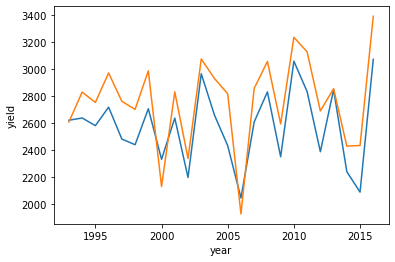

In [316]:
sns.lineplot(data=ha_yield_group, x="year", y="yield")
sns.lineplot(data=yield_national, x="year", y="yield")

In [184]:
kfold_cv_dataset = (features_complete
                    .merge(yield_by_group.loc[:, ["zone", "year", "yield"]], how="left", on=["zone", "year"])
                    .dropna()
                    .reset_index(drop=True))

### 6. K-Fold Cross Validation

In [326]:
def kfold_cross_validation(data, national_yield, model="ECMWF"):
    """
    Returns scores on LOO-CV.
        Params:
            data: ...
        Returns:
            result, dataframe: relative RMSE of national yield forecast by init_month 
    """
    
    cv_dataset = (data.loc[data["model"].isin([model, "WS"])]
                  .reset_index(drop=True)
                  .copy())
    
    oct_sept_columns = ['Tmean_Oct', 'Tmean_Sep', 'Tmax_Oct', 'Tmax_Sep', 'Tmin_Oct', 'Tmin_Sep', 'Rain_Oct', 'Rain_Sep']
    national_forecasts_by_year = pd.DataFrame(data={"year":list(range(1993,2017)), 
                                                              "predicted":np.zeros(24)})
    national_forecasts_by_year = national_forecasts_by_year.merge(national_yield, on="year", how="left")
    for season in crop_seasons:
        for group in list(range(1,5)):
            X_train = cv_dataset.loc[(cv_dataset["year"] != season) 
                                        & (cv_dataset["model"].isin([model])) 
                                           & (cv_dataset["zone"] == group), oct_sept_columns].reset_index(drop=True)
            y_train = cv_dataset.loc[(cv_dataset["year"] != season) 
                                        & (cv_dataset["model"].isin([model])) 
                                           & (cv_dataset["zone"] == group), "yield"].reset_index(drop=True)
            X_train += np.random.normal(0, .001, X_train.shape) 
            pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()),
                                     ('selector', SelectKBest(f_regression, k=4)), ('estimator', LinearRegression())])
            reg = pipeline.fit(X_train, y_train)  

            if season <= 2016:
                X_val = cv_dataset.loc[(cv_dataset["year"] == season) 
                                         & (cv_dataset["model"] == model)
                                            & (cv_dataset["zone"] == group), oct_sept_columns].reset_index(drop=True)
                
                y_predicted = reg.predict(X_val)[0]
                if y_predicted < 0:
                    print(y_predicted)
                    print(X_train.mean() - X_val)
                national_forecasts_by_year.loc[national_forecasts_by_year["year"] == season, "predicted"] += y_predicted * group_to_relative_production[group]
    
    return national_forecasts_by_year

In [327]:
for model in ["ECMWF", "NCEP", "UKMO", "MME", "climate", "WS"]:
    res = kfold_cross_validation(kfold_cv_dataset, ha_yield_group, model=model)
    print(model)
    print(np.round(100 * mse(res["yield"], res["predicted"], squared=False)/res["yield"].mean(), 2))

ECMWF
10.43
NCEP
11.51
UKMO
13.06
MME
11.24
climate
11.91
WS
9.96
